In [171]:
#LIBRARIES AND FUNCTION DEFINITION
import pandas as pd
import numpy as np
from numpy import cos, sin
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib tk

#Cleaning database from infs and nans
def clean(df, nans=True, inf=True):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any('columns')
    return df[indices_to_keep].astype(np.float64)

def plx_filter(df, filter_out_zeros=True, filter_out_negatives=True):
    if filter_out_zeros:
        df = df.loc[df['plx'] != 0.0]
    if filter_out_negatives:
        df = df.loc[df['plx'] > 0.0]
    return df

#Scaling alternative 1: unbiased standard scaling scaled = (x-u)/s
def standard_scaling(df):
    df = df.apply(lambda x: (x - x.mean()) / x.std())
    return df
    
#Scaling alternative 2: softmax y=(x-u)/(r*s) and then scaled = 1/(1+exp(-y)) where r is user defined
#basically is a squashing function that limits the data in the [0, 1], in such a way that values away
#from the mean are squashed exponentially
def softmax_scaling(df):
    r = 1.0
    df = df.apply(lambda x: 1.0/(1.0 + np.exp((x - x.mean()) / (r * x.std()))))
    return df

#MAD(X) = Med{|x− Med(X)|} o bien
#MADN=MAD(X)/0,6445
def robust_scaling(df):
    df = df.apply(lambda x: (x - x.median()) / x.mad())
    return df

def minmax_scaling(df):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(copy=False)
    X = df.to_numpy()
    scaler.fit(X)
    scaler.transform(X)
    df.iloc[:, :] = X
    return df

#Adds rect coords and
def rect_coors(df):
    #rect coors and distance
    df['d'] = df['plx'].apply(lambda plx: np.float64(1000.0/plx if plx != 0.0 else 1000.0/(plx + 0.00000000001)))
    df['x'] = df.d*cos(df.ra)*cos(df.de)
    df['y'] = df.d*sin(df.ra)*cos(df.de)
    df['z'] = df.d*sin(df.de)
    return df

#DBSCAN clustering function
def dbscan(df):
    #Set DBSCAN data to use
    dbscan_vars = ['ra','de','pmra','pmde', 'plx'] #vars to use
    sample_weight = None #array of weights for each sample
    X = df[dbscan_vars].to_numpy()
    
    #Set DBSCAN parameters
    min_samples = 9 #minimum number of neighbours for a point to be considered as a "core point"
    max_distance = 0.38 #radious that defines the neighbourhood of a point
    distance_metric = 'mahalanobis' #choosen from: cityblock, cosine, euclidean, l1, l2, manhattan,
                                  #braycurtis, canberra, chebyshev, correlation, dice, hamming,
                                  #jaccard, kulsinski, mahalanobis, minkowski, rogerstanimoto,
                                  #russellrao, seuclidean, sokalmichener, sokalsneath, sqeuclidean, yule
    #info: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances
    metric_params = {'V': np.cov(X, rowvar=False)}
    algorithm = 'auto' #chosen from: auto, ball_tree, kd_tree, brute
    #info: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
    n_jobs = -1 #number of parallel jobs. None=1, -1 = "use all processors"

    dbscan = DBSCAN(eps=max_distance,
                            min_samples=min_samples,
                            metric=distance_metric,
                            metric_params=metric_params,
                            algorithm=algorithm,
                            n_jobs = n_jobs)

    #Perform clustering and save labels
    dbscan_result = dbscan.fit(X=X, sample_weight=sample_weight)
    df['label'] = dbscan_result.labels_
    return df

#Plots densities of all vars
def densities_plot(df, grid_rows=4, grid_cols=4, figsize=(20, 20)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Densities")
    fig.subplots_adjust(left=0.12, right=0.97,
                            bottom=0.21, top=0.9, wspace=0.5)
    grid_index = 1
    for key, value in df.iteritems():
        ax = fig.add_subplot(grid_rows, grid_cols, grid_index)
        ax.hist(value.to_numpy(), 300, density=True, histtype='stepfilled', alpha=0.4)
        ax.text(0.04, 0.96, str(key),
                ha='left', va='top',
                transform=ax.transAxes)
        grid_index += 1
    return fig

def spatial_plot(df, grid_rows=1, grid_cols=1, figsize=(20, 20)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Spatial")
    ax = fig.add_subplot(1,1,1, projection='3d')
    if 'label' in df:
        ax.scatter3D(df['de'],df['ra'],df['plx'], c=df['label'], cmap='viridis')
    ax.scatter3D(df['de'],df['ra'],df['plx'], c='grey', marker='.', s=1)
    #ax.scatter3D(df["de"], df["ra"], df["plx"], c='grey', marker='.', s=1)
    return fig

def motion_plot(df, grid_rows=1, grid_cols=1, figsize=(20, 20)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Proper Motion")
    ax = fig.add_subplot()
    if 'label' in df:
        ax.scatter(df['pmra'],df['pmde'], c=df['label'], cmap='viridis')
    ax.scatter(df['pmra'],df['pmde'], c='grey', marker='.', s=1)
    #ax.scatter3D(df["de"], df["ra"], df["plx"], c='grey', marker='.', s=1)
    return fig

def motion_plx_plot(df, grid_rows=1, grid_cols=1, figsize=(20, 20)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Proper Motion / Parallax")
    ax = fig.add_subplot(1,1,1, projection='3d')
    if 'label' in df:
        ax.scatter3D(df['pmra'],df['pmde'],df['plx'], c=df['label'], cmap='viridis')
    ax.scatter3D(df['pmra'],df['pmde'],df['plx'], c='grey', marker='.', s=1)
    #ax.scatter3D(df["de"], df["ra"], df["plx"], c='grey', marker='.', s=1)
    return fig

In [172]:
#DATA LOADING AND PREPROCESSING
variables = ['RAJ2000', 'DEJ2000', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Gmag']
new_names = ['ra', 'de', 'plx', 'eplx', 'pmra', 'epmra', 'pmde', 'epmde', 'gmag']

#Loading data and renaming columns
df = pd.read_csv("ic2395.csv", usecols=variables)
df.rename(columns=dict(zip(variables, new_names)), inplace=True)

#Clean inf, nans
df = clean(df)
df = df[df['gmag'] <= 16]
#df = plx_filter(df)
#df = rect_coors(df)
#df = standard_scaling(df)
df.shape

(4660, 9)

In [173]:
df

,plx,eplx,pmra,epmra,pmde,epmde,gmag,ra,de
11,-3.3575,0.3589,-1.199,0.697,2.542,0.541,14.5306,130.876899,-48.062277
41,-3.4555,0.5361,-3.009,1.099,-0.228,0.980,12.1651,131.310420,-47.991267
77,-0.5293,0.0987,-3.698,0.170,4.677,0.186,15.6628,130.248562,-47.680613
86,-0.9829,0.1891,-3.223,0.432,4.642,0.325,14.1917,129.992287,-48.164453
91,-3.7375,0.7245,-2.910,1.237,3.280,1.189,14.1196,131.136954,-48.268084
...,...,...,...,...,...,...,...,...,...
93391,10.5666,0.0301,-53.556,0.052,61.070,0.052,11.0863,130.021391,-47.864539
93392,12.3808,0.0312,14.404,0.049,16.806,0.048,13.5839,130.362051,-48.367739
93393,9.3878,0.0178,-33.003,0.031,26.418,0.028,13.0527,130.855458,-47.900605
93394,15.1848,0.0265,39.801,0.045,60.901,0.043,9.7830,130.927886,-47.840183


In [174]:
#fig = spatial_plot(df)
#fig = densities_plot(df)

In [175]:

    
df1 = robust_scaling(df)
df2 = standard_scaling(df)
df3 = minmax_scaling(df2)

#df.values = scaler.transform(df1.to_numpy())

In [182]:
from sklearn.neighbors import NearestNeighbors


def kdist(df, k):
    X = df.to_numpy()
    neigh = NearestNeighbors(n_neighbors=k+1,
                             metric='mahalanobis',
                             metric_params={'V': np.cov(X, rowvar=False)},
                             n_jobs=-1)
    neigh.fit(X)
    #append distance to k-neighbour
    df[str(k)+'-dist'] = neigh.kneighbors(X)[0][:,k]
    df = df.sort_values(by=str(k)+'-dist')
    fig = plt.figure()
    fig.suptitle(str(k)+'-dist')
    ax = fig.gca()
    ax.set_xticks(np.arange(0, df.shape[0], 1), minor=True)
    ax.set_yticks(np.arange(0, df[str(k)+'-dist'].max(), 0.1) , minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    plt.plot(range(0, df.shape[0]), df[str(k)+'-dist'].to_numpy())
    return df

dfs = kdist(df3.loc[:,['ra','de','plx','pmde', 'pmra']].sample(n=100, random_state=1), 9)
#    plt.grid()
#densities_plot(dfs)
print(dfs)


             ra        de       plx      pmde      pmra    9-dist
90128  0.766322  0.678608  0.055709  0.101368  0.823185  0.734567
90594  0.863392  0.623660  0.055667  0.098940  0.827026  0.783575
88893  0.225856  0.659566  0.054626  0.101273  0.825797  0.797171
90426  0.182446  0.699865  0.056906  0.100669  0.825151  0.829494
85590  0.673420  0.778281  0.054747  0.100464  0.829446  0.846205
...         ...       ...       ...       ...       ...       ...
93277  0.694103  0.336887  0.088746  0.115539  0.769108  3.950259
93291  0.108749  0.486777  0.103033  0.096405  0.778069  4.532425
92400  0.452895  0.518401  0.065664  0.086608  0.787678  5.076437
93380  0.928942  0.397757  0.134557  0.096748  0.787239  5.833503
93320  0.664801  0.435660  0.097226  0.065770  0.885953  6.990604

[100 rows x 6 columns]


In [183]:
df3

,plx,eplx,pmra,epmra,pmde,epmde,gmag,ra,de
11,0.005249,0.383123,0.832294,0.444665,0.099372,0.343979,0.861498,0.666330,0.537202
41,0.003895,0.580649,0.827600,0.711067,0.096221,0.636061,0.638531,0.957473,0.608545
77,0.044315,0.093078,0.825813,0.095427,0.101800,0.107784,0.968216,0.244353,0.920654
86,0.038049,0.193847,0.827045,0.269052,0.101761,0.200266,0.829554,0.072245,0.434548
91,0.000000,0.790659,0.827856,0.802518,0.100211,0.775116,0.822758,0.840977,0.330431
...,...,...,...,...,...,...,...,...,...
93391,0.197581,0.016609,0.696506,0.017230,0.165948,0.018629,0.536845,0.091790,0.735867
93392,0.222640,0.017835,0.872760,0.015242,0.115597,0.015968,0.772264,0.320569,0.230308
93393,0.181298,0.002898,0.749810,0.003313,0.126531,0.002661,0.722194,0.651931,0.699632
93394,0.261372,0.012596,0.938627,0.012591,0.165756,0.012641,0.413999,0.700571,0.760337


In [184]:
df3 = dbscan(df3)

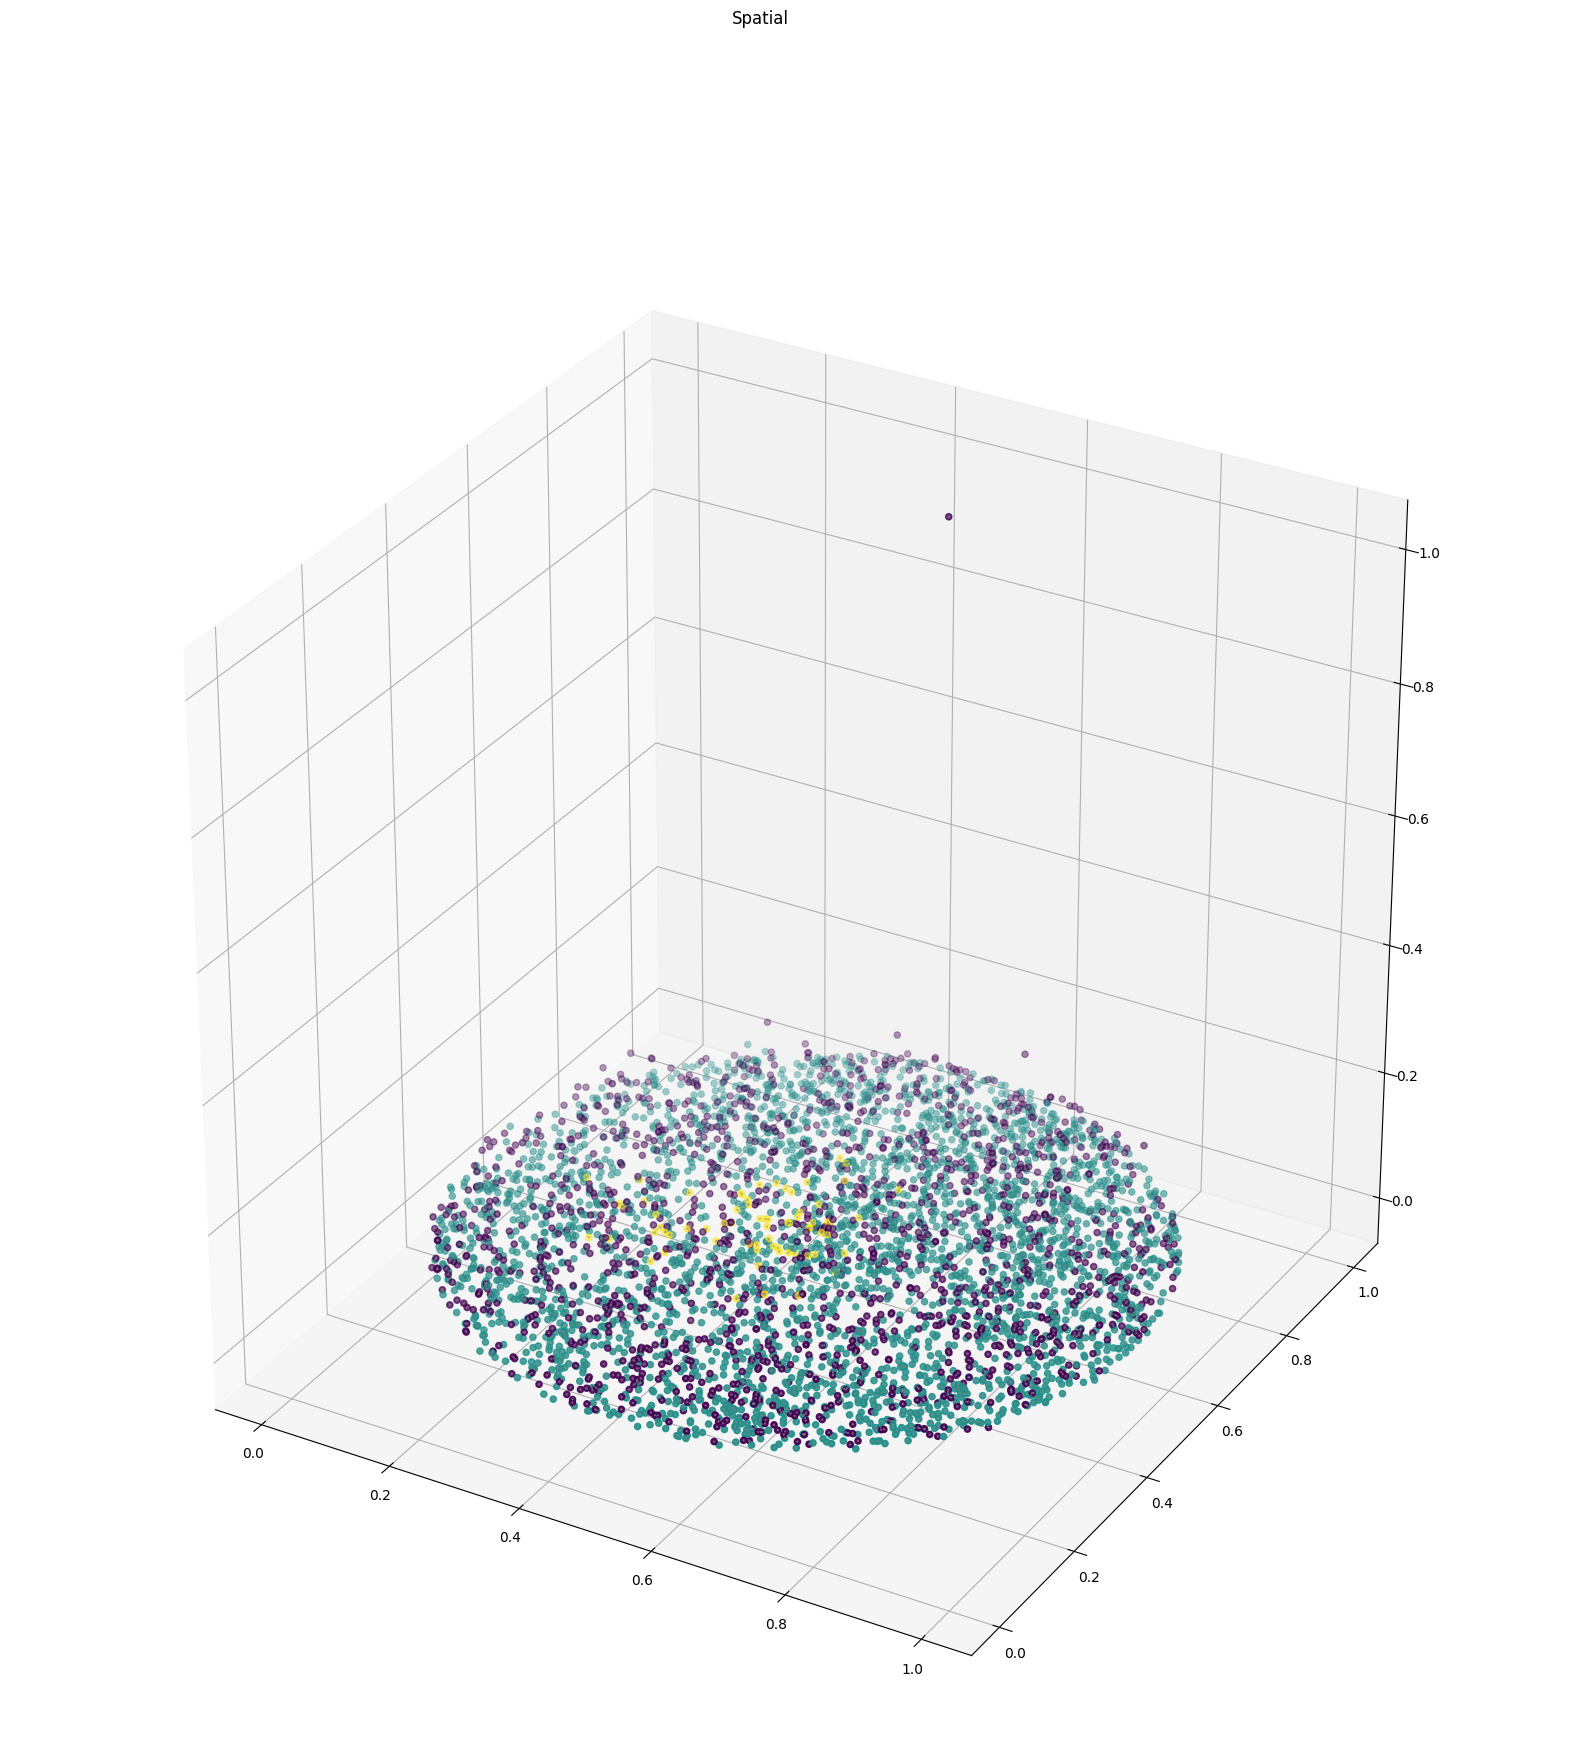

In [185]:
spatial_plot(df3)

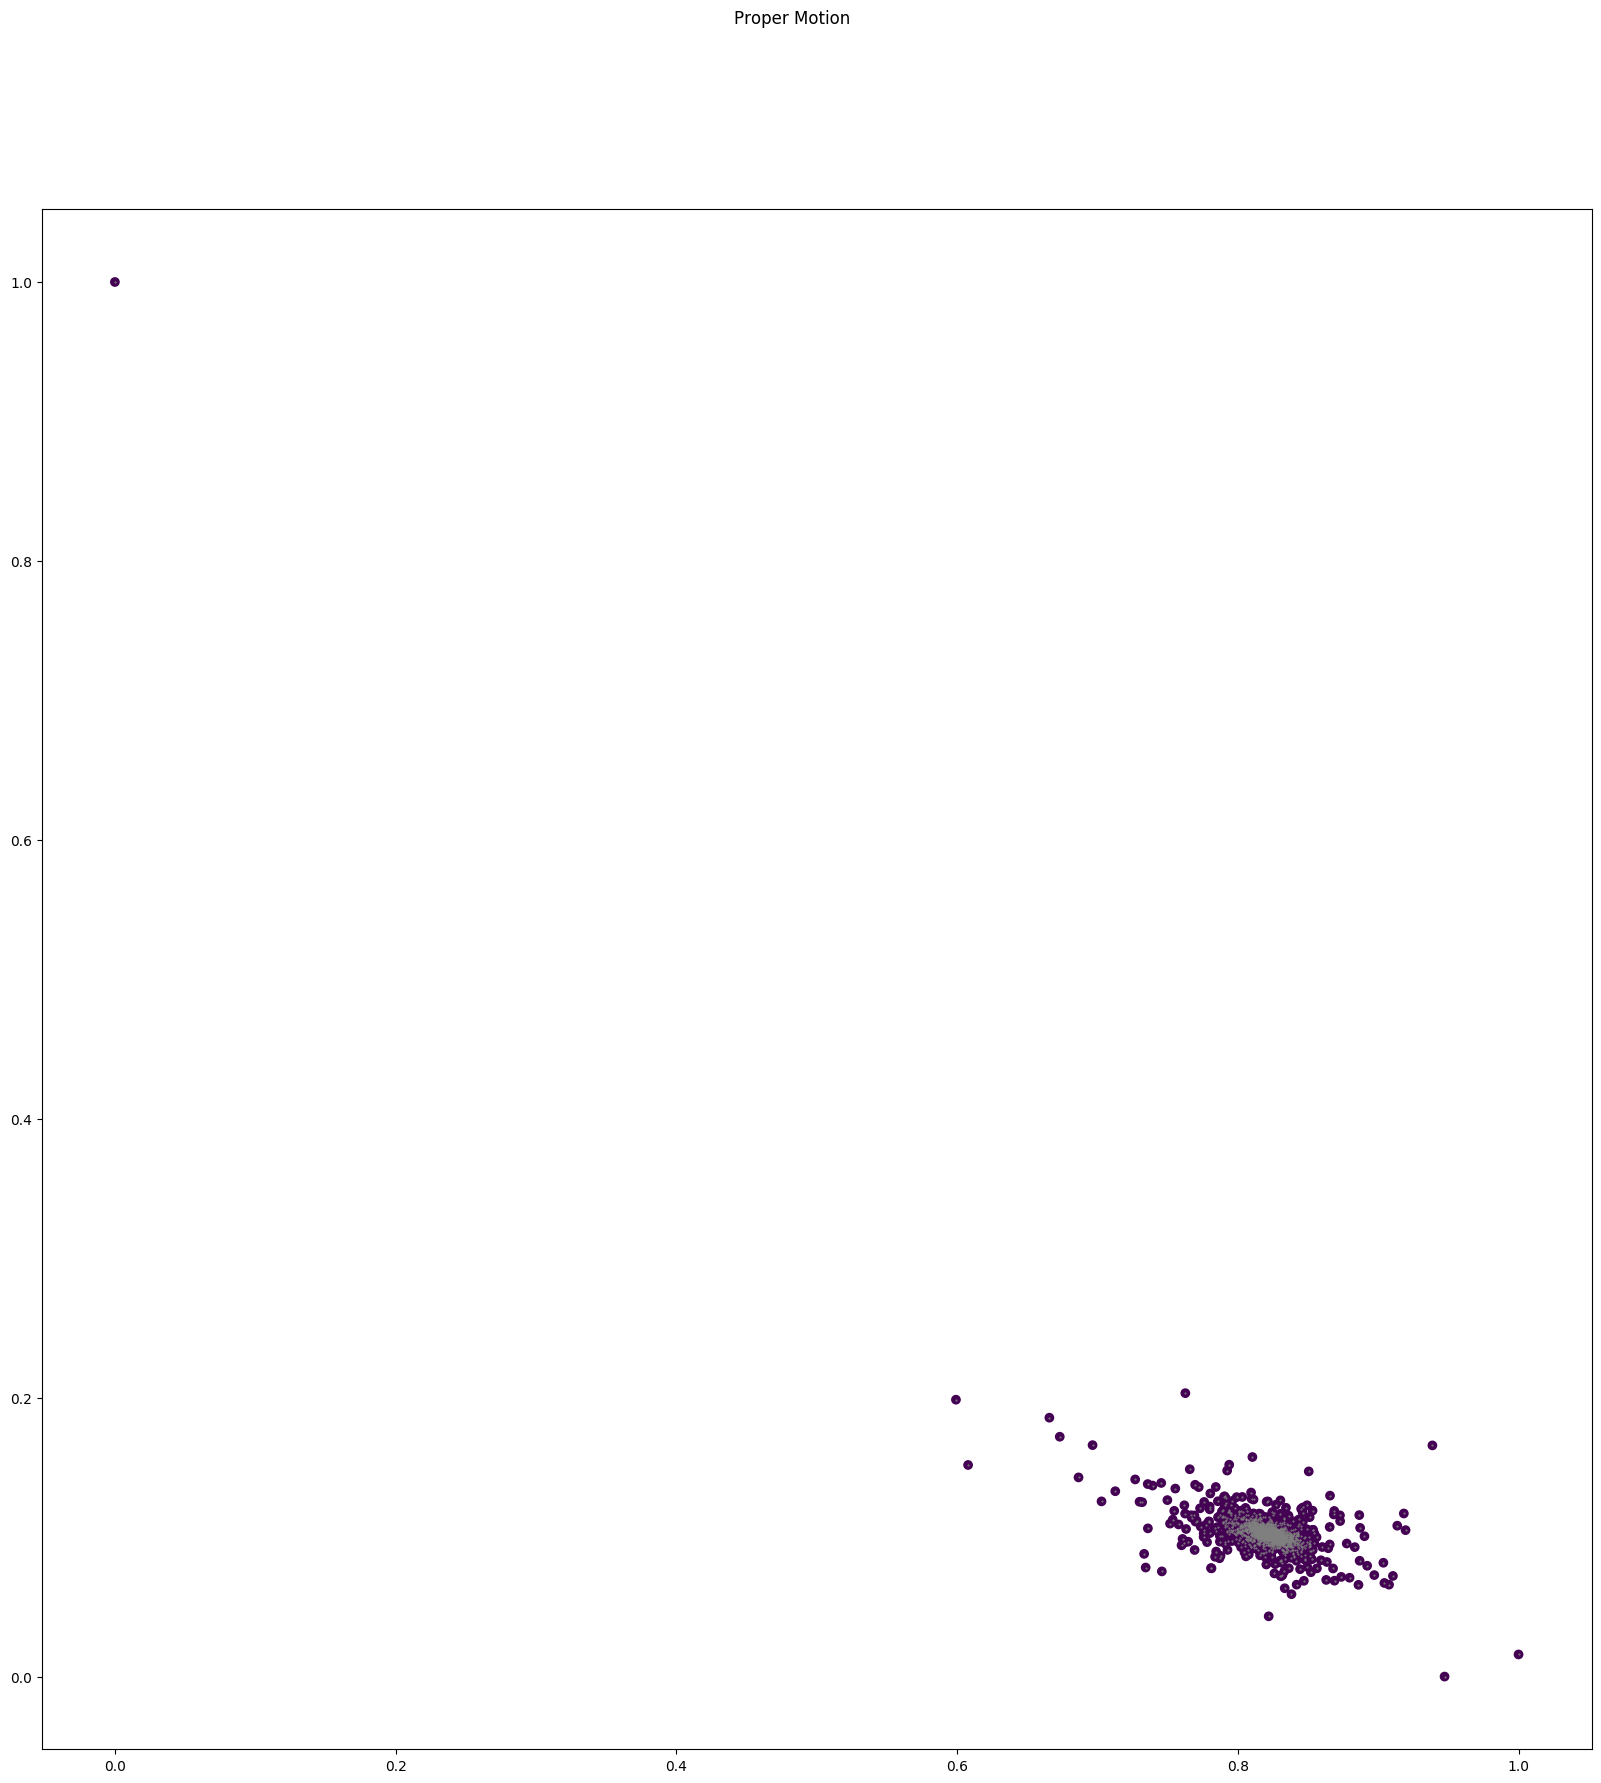

In [186]:
motion_plot(df3)

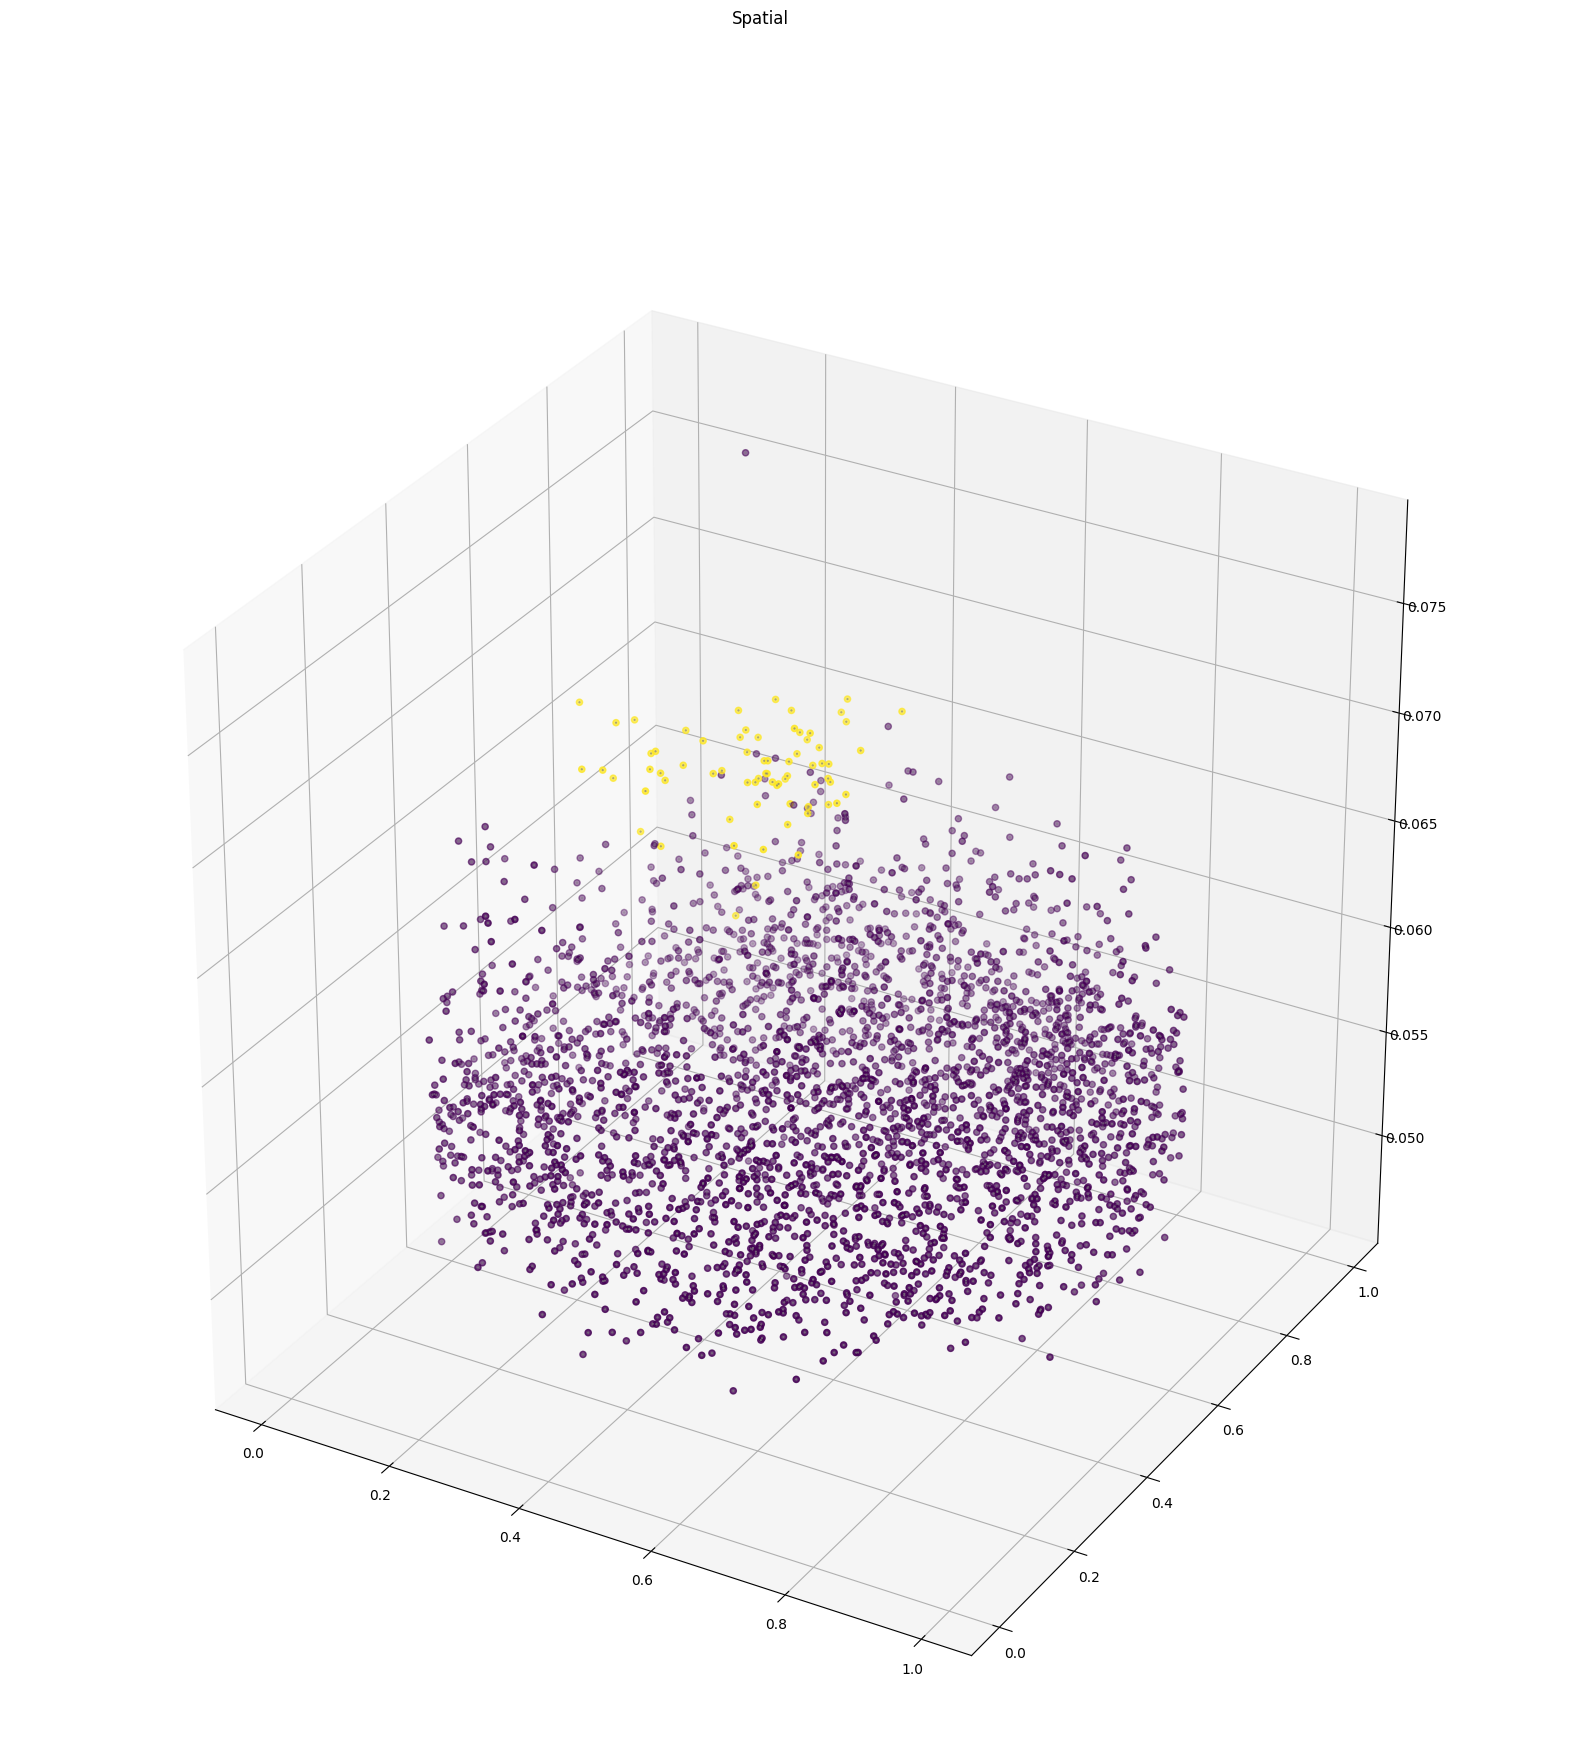

In [187]:
spatial_plot(df3[df3["label"]!=-1])

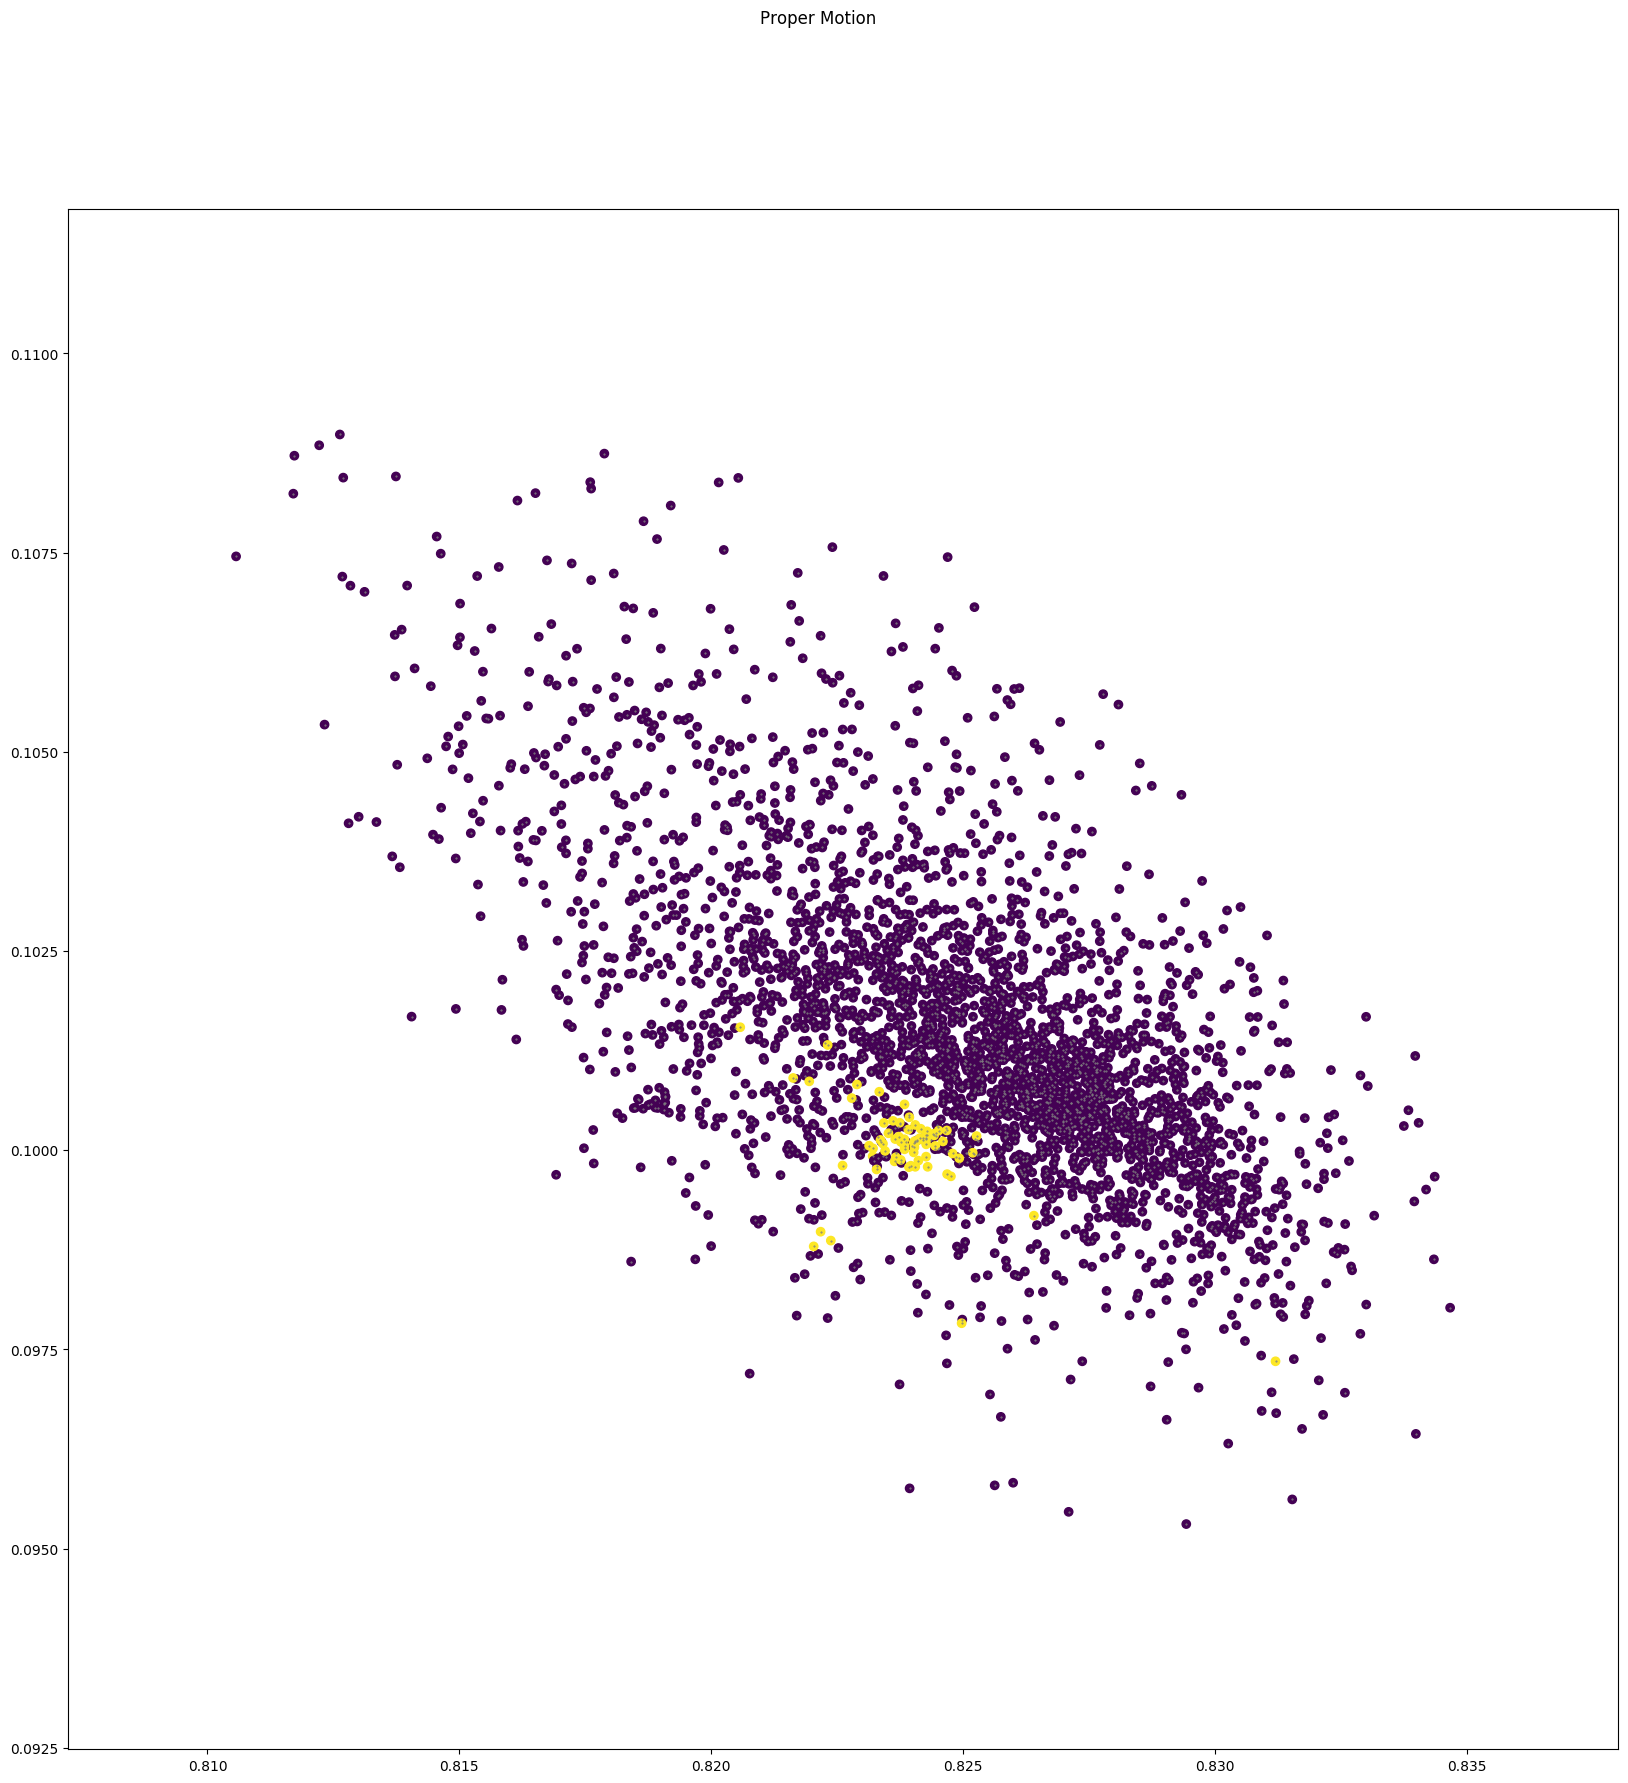

In [188]:
motion_plot(df3[df3["label"]!=-1])

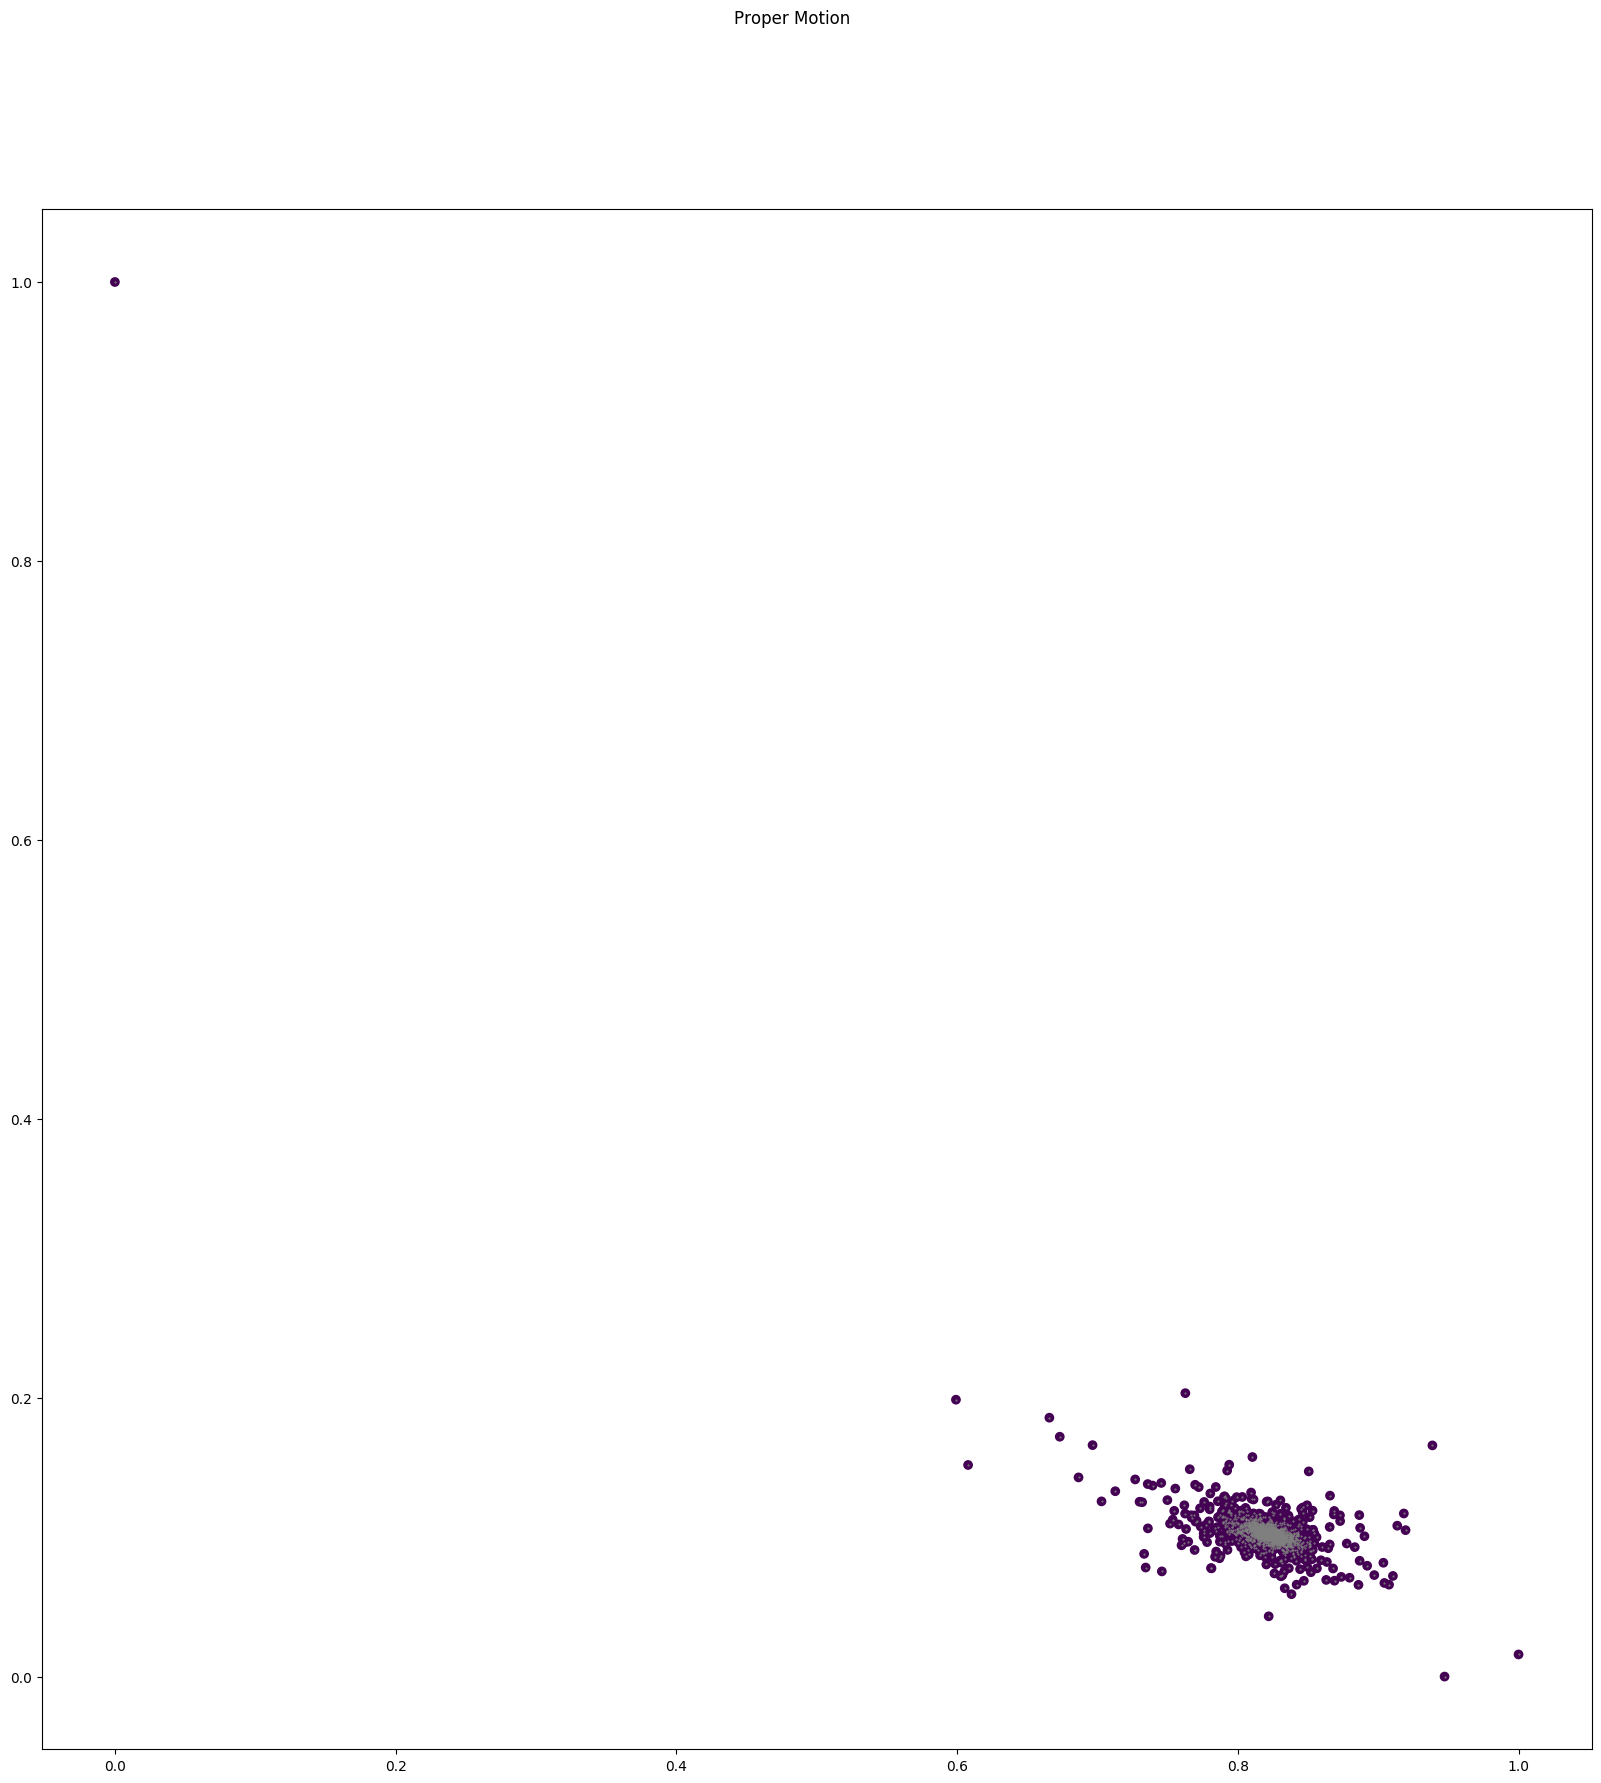

In [189]:
motion_plot(df3)

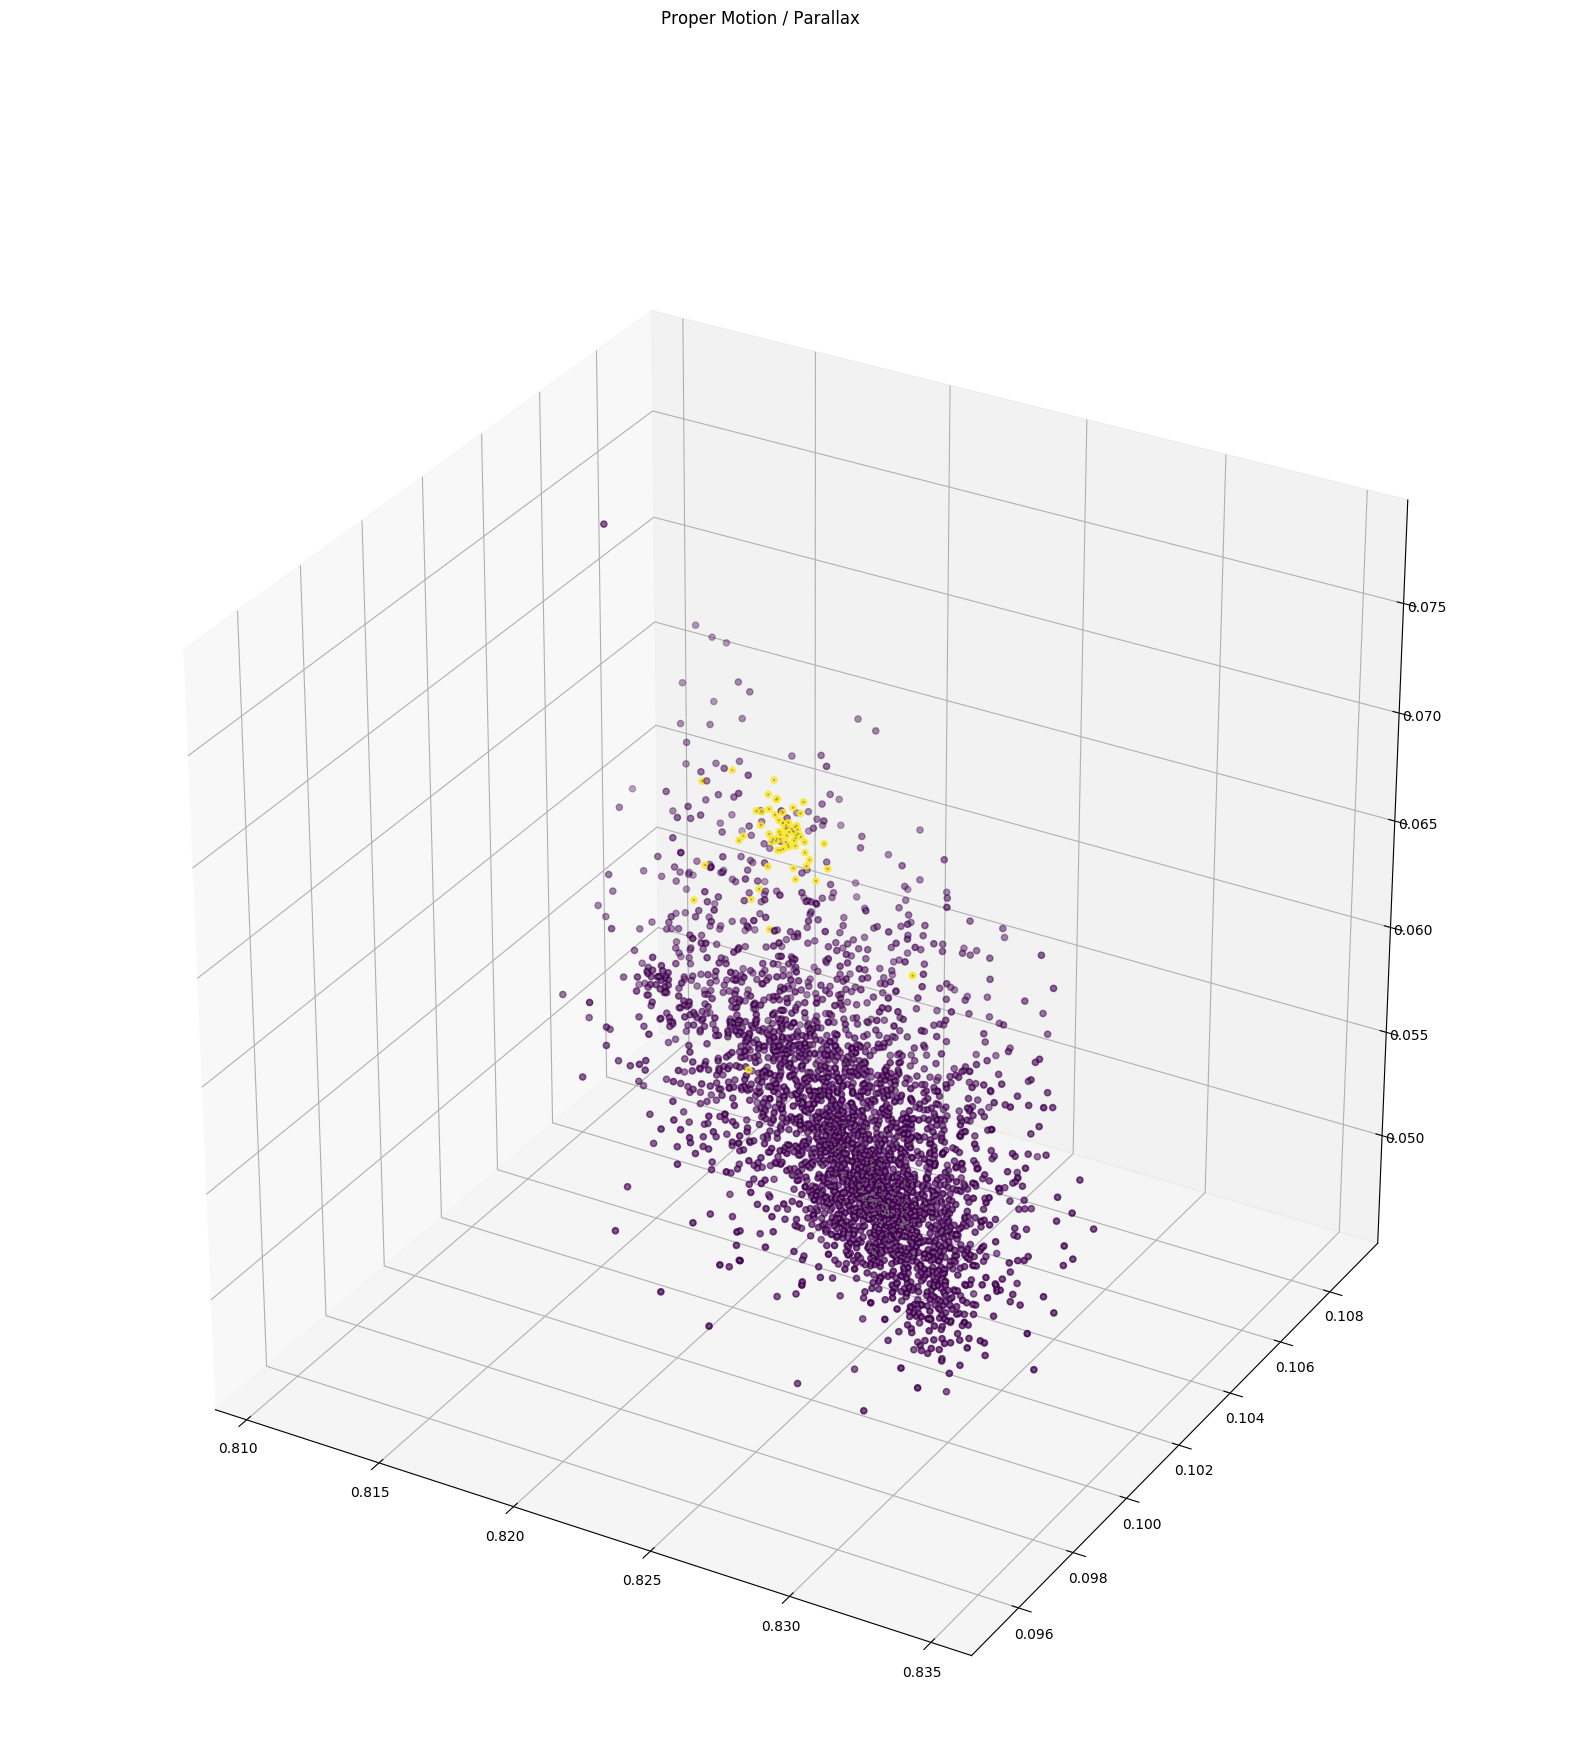

In [190]:
motion_plx_plot(df3)
motion_plx_plot(df3[df3['label']!=-1])

In [30]:
plt.hist(df.iloc[(df['label'] != -1),].to_numpy(), 3000, density=True, histtype='stepfilled', alpha=0.4)

NotImplementedError: iLocation based boolean indexing on an integer type is not available

(array([0.00033397, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00033397]),
 array([-27.5216    , -27.48953993, -27.45747987, ...,  68.59447987,
         68.62653993,  68.6586    ], dtype=float128),
 <a list of 1 Patch objects>)

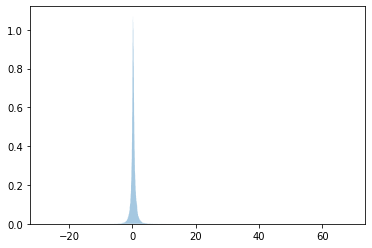

In [87]:
plt.hist(df['ra'].to_numpy(), 3000, density=True, histtype='stepfilled', alpha=0.4)

In [4]:
import sys
sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [4]:
df

,ra,de,plx,eplx,pmra,epmra,pmde,epmde,gmag
0,-13.5959,0.6379,5.262,1.000,54.893,1.890,19.6276,131.232826,-48.006292
1,-6.9147,0.4484,19.903,0.874,4.432,0.801,17.9192,130.203236,-48.285494
2,-19.8164,1.3948,-19.800,1.714,-29.599,3.636,20.2690,130.666884,-48.151818
3,-16.1700,1.1870,10.386,1.976,-55.356,2.049,19.3245,130.988267,-48.352949
4,-6.2332,0.4823,17.091,1.014,-3.194,1.641,18.8136,130.522039,-48.274939
...,...,...,...,...,...,...,...,...,...
93391,10.5666,0.0301,-53.556,0.052,61.070,0.052,11.0863,130.021391,-47.864539
93392,12.3808,0.0312,14.404,0.049,16.806,0.048,13.5839,130.362051,-48.367739
93393,9.3878,0.0178,-33.003,0.031,26.418,0.028,13.0527,130.855458,-47.900605
93394,15.1848,0.0265,39.801,0.045,60.901,0.043,9.7830,130.927886,-47.840183


In [ ]:

#loading a df from numpy
"""tabla= np.genfromtxt('ic2395.csv',
                     delimiter=',',
                     skip_header=1,
                     names=variables,
                     dtype="longdouble",
                     usecols=variables)
df1 = pd.DataFrame(tabla)
"""

